A character-level language model serves as an accessible entry point for grasping more complex sequence models like LSTM (Long Short-Term Memory).

Illustrating this concept, I present a basic implementation of name generation using a Recurrent Neural Network (RNN). The dataset, sourced from Retraite Québec, consists of first names belonging to children eligible for family benefits. These names encompass both genders and encompass individuals born in Québec or those who've immigrated there starting from 1980.

By delving into this RNN-driven approach, we can glean insights into how sequence models work. Such models find broad utility in diverse fields like natural language processing, genetics, and even music generation. The RNN's ability to capture patterns and dependencies in sequential data equips us to generate new, plausible names based on the underlying patterns in the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [2]:
# first row is the column name
df1 = pd.read_csv('gars1980-2022.csv', header=0)
df2 = pd.read_csv('filles1980-2022.csv', header=0)

In [3]:
# data cleaning
data1 = df1.dropna()
data2 = df2.dropna()
data1[data1['Prenom_masculin'] == 'Somme:']
data2[data2['Prenom_feminin'] == 'Somme:']
data1 = data1.drop(index=210077)
data2 = data2.drop(index=215648)

In [4]:
# sort by frequency from high to low
data_sorted1 = data1.sort_values(by='Total', ascending=False)
data_sorted1.reset_index(inplace=True, drop=True)

data_sorted2 = data2.sort_values(by='Total', ascending=False)
data_sorted2.reset_index(inplace=True, drop=True)

In [5]:
# choose the first 10000 names
names1 = data_sorted1[:5000]
names2 = data_sorted2[:5000]
names1 = names1['Prenom_masculin'].str.lower().to_list()
names2 = names2['Prenom_feminin'].str.lower().to_list()
names = names1 + names2

Design and train a trigram language model, i.e. take two characters as an input to predict the 3rd one. 

In [6]:
# lookup table to match characters to integers
chars = sorted(list(set("".join(names))))
chr_to_idx = {c:i for i,c in enumerate(chars)}
chr_to_idx['<E>'] = 28
vocab_size = len(chr_to_idx)
print(f"vocab_size: {vocab_size}")

idx_to_chr = {i:c for i,c in enumerate(chars)}
idx_to_chr [28] = '<E>'

vocab_size: 29


In [7]:
# generate dataset, input two characters, output one character
x, y = [], []

for name in names:
    unit = list(name) + ['<E>']
    for ch1, ch2, ch3 in zip(unit, unit[1:], unit[2:]):
        ix1 = chr_to_idx[ch1]
        ix2 = chr_to_idx[ch2]
        ix3 = chr_to_idx[ch3]
        x.append([ix1, ix2])
        y.append(ix3)  

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# prepare data for pytorch and generate dataloader
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.long)
        self.y_data = torch.tensor(y_data, dtype=torch.long)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

batch_size = 64
train_ds = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_ds = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# define a funciton for generating 5 names

def generate_names(model, seed='al', temperature=1):
    seed = list(seed)
    idx1 = chr_to_idx[seed[0]]
    idx2 = chr_to_idx[seed[1]]
    seed = torch.tensor([idx1, idx2], dtype=torch.long)
    seed = seed.unsqueeze(0)

    model.eval()
    names = []
    for i in range(5):
        output = ['<S>']
        while output[-1] != '<E>':
            logits = model(seed)
            scaled_logits = logits / temperature
            prob = F.softmax(scaled_logits.data, dim=1)
            predicted = torch.multinomial(prob, 1).squeeze(1)
            chr_predicted = idx_to_chr[predicted.item()]
            output.append(chr_predicted)
            seed = torch.cat((seed[:, -1], predicted)).unsqueeze(0)
        final_output = [idx_to_chr[idx1], idx_to_chr[idx2]] + output[1:-1]
        names.append(''.join(final_output))
    print('\n'.join(names))

In [12]:
# understanding LSTM input and output shapes

for input, label in train_ds: # get the first batch
    break
print(input.shape, label.shape)
a = nn.Embedding(vocab_size, 3)(input) # 3 is the embedding dimension
print(a.shape) # (batch_size, seq_len, input_size/embedding dimension)
b, _ = nn.LSTM(input_size=3, hidden_size=5, batch_first=True)(a) # input_size = embedding dimension
print(b.shape) # (batch_size, seq_len, hidden_size)
print(b[:, -1, :].shape) # -1 means using only the last time step of each seq for prediction

torch.Size([64, 2]) torch.Size([64])
torch.Size([64, 2, 3])
torch.Size([64, 2, 5])
torch.Size([64, 5])


In [13]:
# LSTM model
class Model(nn.Module):
    def __init__(self, num_embeddings=vocab_size, embedding_dim=128, hidden_size=128, out_features=vocab_size):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim) 
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True) 
        self.out = nn.Linear(hidden_size * 2, out_features)

    def forward(self,x):
        x = self.embedding(x)
        x, _= self.lstm(x) # output x of lstm is a tensor of shape (batch_size, seq_len, hidden_size)
        x = torch.cat((x[:, 0, :], x[:, 1, :]), dim=1)  # Concatenate the hidden states of both time steps, shape (batch_size, hidden_size * 2)
        x = self.out(x)
        return x

torch.manual_seed(42)
model = Model()
print(f"total model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"total training examples: {len(X_train)}")
print(f"total test examples: {len(X_test)}")

total model parameters: 143261
total training examples: 46616
total test examples: 11654


In [14]:
# names generated without training
generate_names(model, seed='al')

aloymrpm wgrhvdygpmane c
almmehkzwiombeiizyzirfcapbxdlakaxvcniqw
allfwm-alyiccvl-m--lw xuwgri
alxav-dsjkjkxsma whtaptuoqyofjen
alhgr-whhuovpmvtr-kolpfyx zi pyxecaextm


In [15]:
# training
epochs = 50
learning_rate = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
torch.cuda.empty_cache()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_losses = []
test_losses = []

for epoch in range(epochs):
    # training loop
    model.train()
    
    for X_train, y_train in train_ds: # iternate through all batches of training data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        # Forward pass
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
       
        # Back propagation and update
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    train_losses.append(train_loss.item()) # add training loss during the last batch for each epoch

    # test loop
    model.eval()

    total = 0
    correct = 0
    with torch.no_grad():
        for X_test, y_test in test_ds: # iterate over all batches of test data
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_pred = model(X_test)
            _, predicted = torch.max(y_pred.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
        
    test_loss = criterion(y_pred, y_test)
    test_losses.append(test_loss.item()) # add test loss during the last batch for each epoch
        
print(f"last training loss {train_loss.item():.4f}")
print(f"last test loss: {test_loss.item():.4f}")

last training loss 1.5800
last test loss: 1.5546


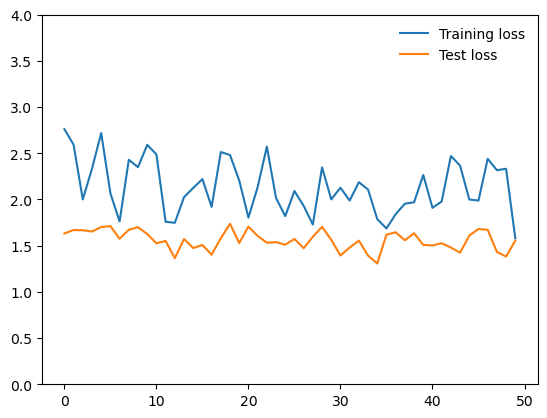

In [16]:
# plot training and test loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)
plt.ylim(0, 4);

In [17]:
# test eval
total = 0
correct = 0
with torch.no_grad():
    for X_test, y_test in test_ds: # iterate over all batches of test data
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        
        y_pred = model(X_test)
        _, predicted = torch.max(y_pred.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

print(f"test eval: {correct}/{total} accuracy: {correct/total*100:.2f}%\n")

test eval: 3973/11654 accuracy: 34.09%



In [20]:
# names generated after training
generate_names(model, seed='al')

alei
ale
al
alannie-chaia
almin


In [21]:
torch.save(model.state_dict(), 'name_model_lstm.pt')